In [2]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=056a1dc0a073a2aa52a0e8170b13af67b7507b00c42e7ad57c5b0c7309e32174
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lime
import lime.lime_tabular
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import train_test_split
from lime.lime_tabular import LimeTabularExplainer

In [36]:
X_train_final = pd.read_csv('/content/X_train_final.csv')
X_test_final = pd.read_csv('/content/X_test_final.csv')
y_train = pd.read_csv('/content/y_train_final.csv').squeeze()
y_test = pd.read_csv('/content/y_test_final.csv').squeeze()

In [37]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"\n{name} Evaluation")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"Precision: {precision_score(y_test, y_pred):.2f}")
    print(f"Recall: {recall_score(y_test, y_pred):.2f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")
    print(f"AUC: {roc_auc_score(y_test, y_pred):.2f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

## Random Forest Model


Random Forest Evaluation
Accuracy: 0.94
Precision: 0.93
Recall: 0.95
F1 Score: 0.94
AUC: 0.94
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93       544
           1       0.93      0.95      0.94       635

    accuracy                           0.94      1179
   macro avg       0.94      0.94      0.94      1179
weighted avg       0.94      0.94      0.94      1179



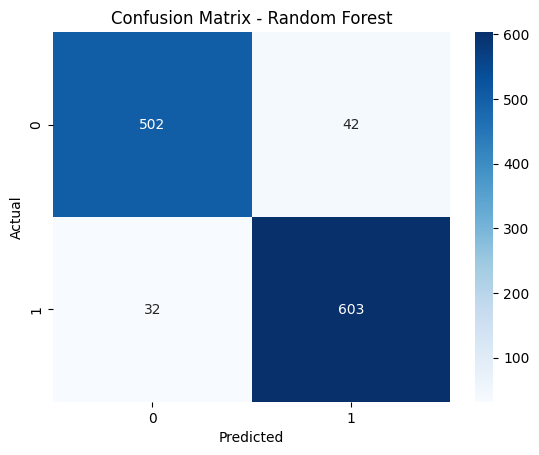

In [38]:
rf_final = RandomForestClassifier(n_estimators=100, random_state=42)
rf_final.fit(X_train_final, y_train)
evaluate_model("Random Forest", rf_final, X_test_final, y_test)

### SHAP for Random Forest

In [39]:
sample_instance = X_test_final.iloc[0]

explainer = LimeTabularExplainer(
    X_train_final.values,
    feature_names=X_train_final.columns.tolist(),
    class_names=['No Churn', 'Churn'],
    discretize_continuous=True
)


SHAP Summary for Random Forest


<Figure size 640x480 with 0 Axes>

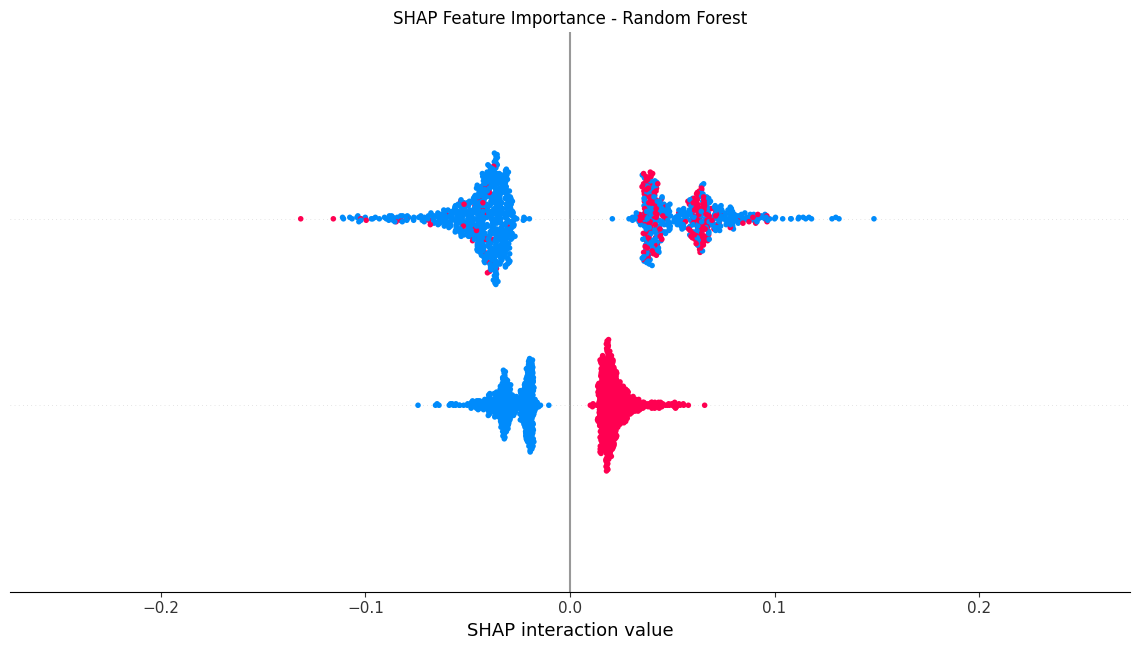

In [41]:
print("\nSHAP Summary for Random Forest")
explainer_rf = shap.TreeExplainer(rf_final)
shap_values_rf = explainer_rf.shap_values(X_test_final)
shap.summary_plot(shap_values_rf, X_test_final, plot_type="bar", show=False)
plt.title("SHAP Feature Importance - Random Forest")
plt.tight_layout()
plt.show()

### LIME for Random Forest

In [42]:
print("\nLIME Explanation for Random Forest")
exp = explainer.explain_instance(sample_instance.values, rf_final.predict_proba)
exp.show_in_notebook()


LIME Explanation for Random Forest


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


This LIME explanation shows that the Random Forest model predicts a 59% chance of churn for the selected customer. The prediction is mainly driven by:

* High MonthlyCostPerTenure

* Very short tenure (≤ 4 months)

* No Tech Support, Online Security, or Device Protection

### PDP for Random Forest

In [43]:
selected_feature = 'MonthlyCostPerTenure'
feature_index = X_train_final.columns.tolist().index(selected_feature)


PDP - Random Forest


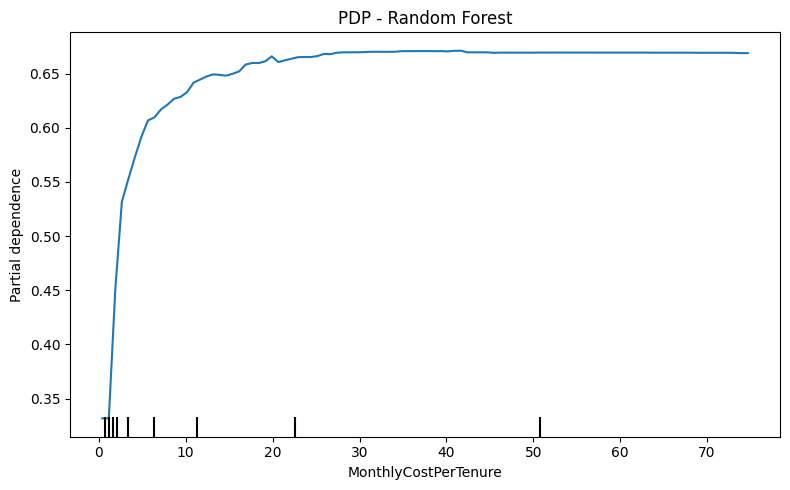

In [44]:
print("\nPDP - Random Forest")
fig, ax = plt.subplots(figsize=(8, 5))
PartialDependenceDisplay.from_estimator(rf_final, X_test_final, [feature_index], ax=ax)
ax.set_title("PDP - Random Forest")
plt.tight_layout()
plt.show()

This PDP shows that as MonthlyCostPerTenure increases, the likelihood of churn also increases—especially sharply at low values.

The curve levels off after around 20, indicating that beyond this point, higher costs don’t significantly raise the churn risk further.

### ICE for Random Forest


ICE - Random Forest


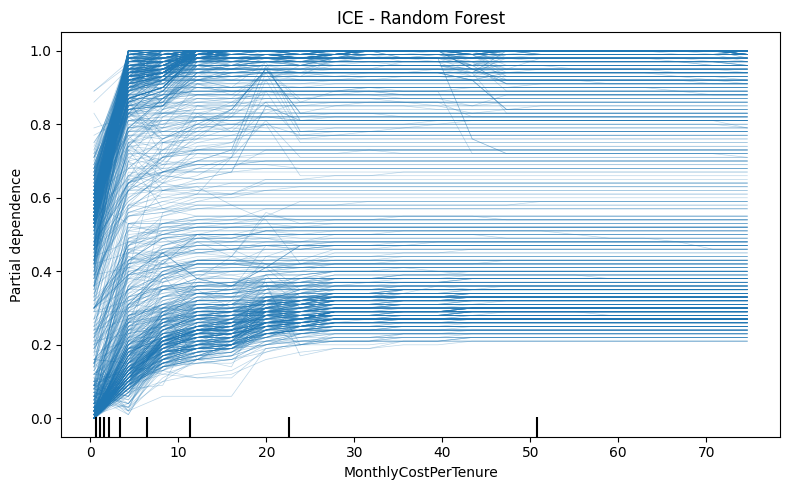

In [45]:
print("\nICE - Random Forest")
fig, ax = plt.subplots(figsize=(8, 5))
PartialDependenceDisplay.from_estimator(rf_final, X_test_final, features=[feature_index], kind="individual", grid_resolution=20, ax=ax)
ax.set_title("ICE - Random Forest")
plt.tight_layout()
plt.show()

This ICE plot illustrates how the MonthlyCostPerTenure feature affects the churn prediction for individual customers.

Most lines trend upward, especially at low values, meaning as MonthlyCostPerTenure increases, predicted churn probability rises for many customers. The variation among lines shows individual sensitivity—some customers are more affected than others. This supports the PDP trend while revealing heterogeneity in individual responses.

## Decision Tree Model


Decision Tree Evaluation
Accuracy: 0.92
Precision: 0.92
Recall: 0.93
F1 Score: 0.92
AUC: 0.92
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.91      0.91       544
           1       0.92      0.93      0.92       635

    accuracy                           0.92      1179
   macro avg       0.92      0.92      0.92      1179
weighted avg       0.92      0.92      0.92      1179



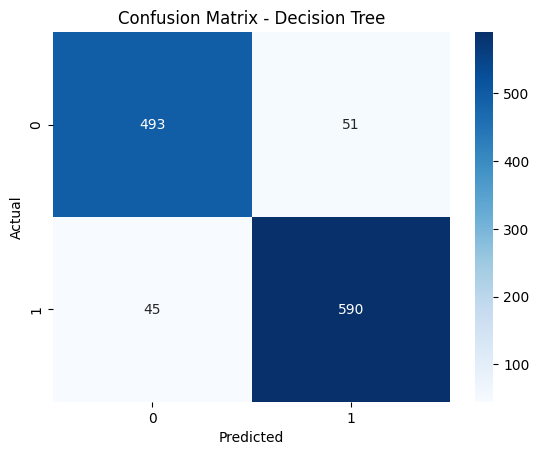

In [46]:
dt_final = DecisionTreeClassifier(random_state=42)
dt_final.fit(X_train_final, y_train)
evaluate_model("Decision Tree", dt_final, X_test_final, y_test)

### SHAP for Decision Tree


SHAP Summary for Decision Tree


<Figure size 640x480 with 0 Axes>

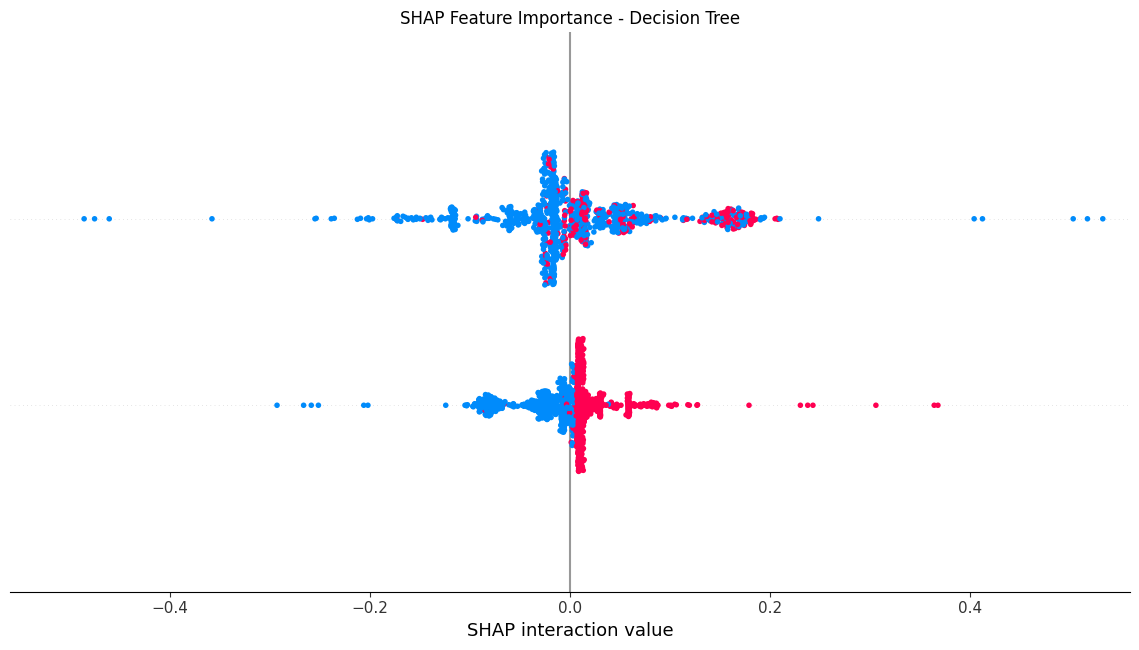

In [47]:
print("\nSHAP Summary for Decision Tree")
explainer_dt = shap.TreeExplainer(dt_final)
shap_values_dt = explainer_dt.shap_values(X_test_final)
shap.summary_plot(shap_values_dt, X_test_final, plot_type="bar", show=False)
plt.title("SHAP Feature Importance - Decision Tree")
plt.tight_layout()
plt.show()

### LIME for Decision Tree

In [48]:
print("\nLIME Explanation for Decision Tree")
exp = explainer.explain_instance(sample_instance.values, dt_final.predict_proba)
exp.show_in_notebook()


LIME Explanation for Decision Tree


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


This LIME explanation shows that the model predicts churn with 100% certainty for the selected customer. The most influential factors contributing to this decision are:

* High MonthlyCostPerTenure (43.80) and absence of Device Protection, both strongly pushing the prediction toward churn.

* Additional churn drivers include:
  * Low TotalCharges (≤ 247.16),
  * Lack of Tech Support and Online Security,
  * Negative discount score (paying more than average).

In contrast, features like DeviceProtection_Yes, OnlineSecurity_Yes, and PaperlessBilling_Yes slightly favor "No Churn," but their influence is minimal in this case.

### PDP for Decision Tree


PDP - Decision Tree


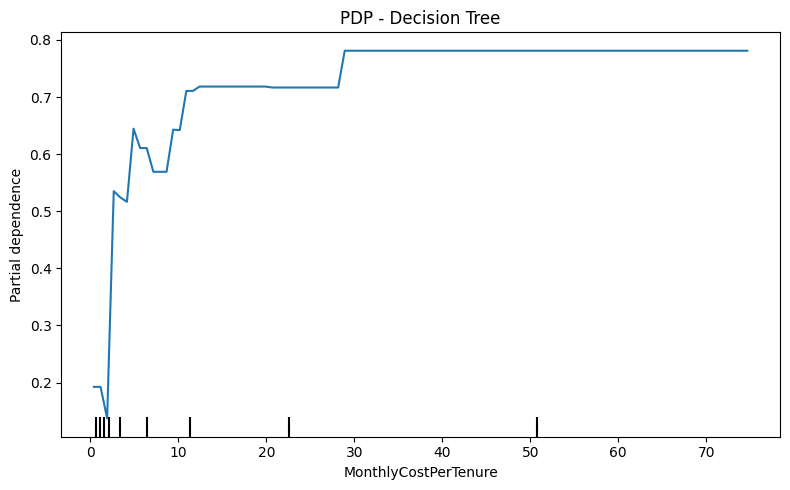

In [49]:
print("\nPDP - Decision Tree")
fig, ax = plt.subplots(figsize=(8, 5))
PartialDependenceDisplay.from_estimator(dt_final, X_test_final, [feature_index], ax=ax)
ax.set_title("PDP - Decision Tree")
plt.tight_layout()
plt.show()

This Partial Dependence Plot illustrates how the feature MonthlyCostPerTenure affects the predicted probability of churn:

  * As MonthlyCostPerTenure increases from 0 to around 10, the churn probability rises sharply.

  * After a certain threshold (~10), the model predicts a consistently high churn probability (around 0.78).

  * The flat segments indicate the model's decision thresholds typical in tree-based models.

Customers who pay more relative to their tenure are significantly more likely to churn, and the model treats this relationship in discrete steps.

### ICE for Decision Tree


ICE - Decision Tree


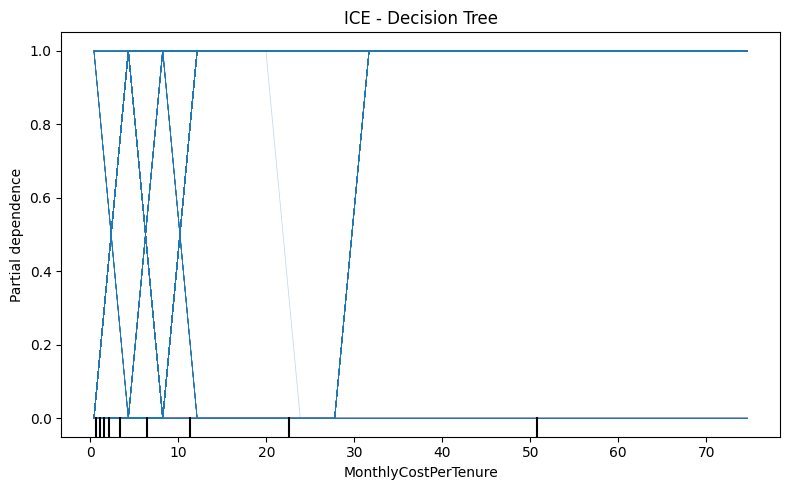

In [50]:
print("\nICE - Decision Tree")
fig, ax = plt.subplots(figsize=(8, 5))
PartialDependenceDisplay.from_estimator(dt_final, X_test_final, features=[feature_index], kind="individual", grid_resolution=20, ax=ax)
ax.set_title("ICE - Decision Tree")
plt.tight_layout()
plt.show()

This ICE shows how predictions vary per individual as the feature MonthlyCostPerTenure changes:

  * The sharp vertical lines represent sudden changes in prediction, which is characteristic of decision trees due to their step-like splits.

  * Each line corresponds to a different customer; the model's prediction either jumps to a high or low value when crossing decision thresholds.

  * Many lines abruptly jump to 1.0 (high churn probability) at low MonthlyCostPerTenure, confirming that the model considers even small increases as strong churn indicators.

The Decision Tree model makes abrupt decisions based on MonthlyCostPerTenure, and for many users, a slight increase in cost leads to a strong shift in churn prediction.